#**Lab 6: Introduction to Machine Learning (Prediction Models)**

# RPAD 676: Data Science for the Public Good

## Author: Sachin Mitra
## Date: 5/15/25

## Instructions
This lab uses NYC 311 data from the NYC Open Data portal to predict resolution wait times. We experimented with different types of models, including features, and evaluating performance.

Prompts were given in each section to write the necessary Python code to complete the tasks.

Thought process and reflections were denoted in markdown cells throughout the notebook.

In [2]:
# OPTIONAL: Remove # and run this cell ONLY if using Google Colab or a new environment
!pip install -q pandas numpy matplotlib seaborn nltk scikit-learn gensim spacy wordcloud sodapy textblob
!python -m nltk.downloader stopwords punkt wordnet
!python -m spacy download en_core_web_sm
from textblob import download_corpora; download_corpora.download_all()

/opt/anaconda3/envs/nlp311/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package brown to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sodapy import Socrata
from datetime import datetime

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from textblob import TextBlob

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
# Download NLP resources (run once per environment)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
spacy.cli.download("en_core_web_sm")

from textblob import download_corpora
download_corpora.download_all()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.4 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package brown to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sachinfmitra/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Predicting 311 Wait Times With NYC 311 Data

#### CONNECT TO NYC OPEN DATA API


In [5]:
client = Socrata("data.cityofnewyork.us", app_token=None)
dataset_id = "erm2-nwe9"

# Paginate to retrieve more than 10,000 records
limit = 10000
offset = 0
MAX_RECORDS = 10000  # Set your custom total limit
all_results = []

# Filter by recent date - change as needed
date_filter = "created_date > '2025-01-01T00:00:00.000'"

while offset < MAX_RECORDS:
    current_limit = min(limit, MAX_RECORDS - offset)
    results = client.get(dataset_id, limit=current_limit, offset=offset, where=date_filter)

    if not results:
        break

    print(f"Fetched records {offset} to {offset + current_limit}")
    all_results.extend(results)
    offset += current_limit
    time.sleep(1)

Fetched records 0 to 10000


In [6]:
# Create DataFrame
df = pd.DataFrame.from_records(all_results)
print(f"Total records retrieved: {len(df)}")

Total records retrieved: 10000


In [7]:
# Show columns
print(df.columns)
print(df.head())

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'facility_type', 'vehicle_type',
       'bridge_highway_name', 'bridge_highway_direction',
       'bridge_highway_segment', 'taxi_pick_up_location', 'due_date',
       'road_ramp', 'taxi_company_borough'],
      dtype='object')
  unique_key             created_date              closed_date agency  \
0   63577994  2025-01-01T00:00:12.000  2025-01-02T17:05:54.000   NYPD   
1   635

#### PREPROCESSING & FEATURE ENGINEERING

In [8]:
df["created_date"] = pd.to_datetime(df["created_date"], errors='coerce')
df["closed_date"] = pd.to_datetime(df["closed_date"], errors='coerce')
df = df.dropna(subset=["created_date", "closed_date"])

# Ensure the DataFrame is not a view to avoid SettingWithCopyWarning
df = df.copy()
df["response_time_days"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 86400


In [9]:
# Remove unreasonable values (e.g., negatives or very long durations)
df = df[(df["response_time_days"] >= 0) & (df["response_time_days"] < 365)]

In [10]:
# Select features and encode categoricals
df_model = df[["complaint_type", "borough", "agency", "response_time_days"]].dropna()
df_model = pd.get_dummies(df_model, columns=["complaint_type", "borough", "agency"], drop_first=True)

#### TRAIN/TEST SPLIT

In [11]:
# Train/test split
X = df_model.drop("response_time_days", axis=1)
y = df_model["response_time_days"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # use random_state to ensure reproducibility

#### TRAIN MODELS & EVALUATE

Training models...

Linear Regression Results:
MAE: 2.63, RMSE: 9.24, R2: 0.35


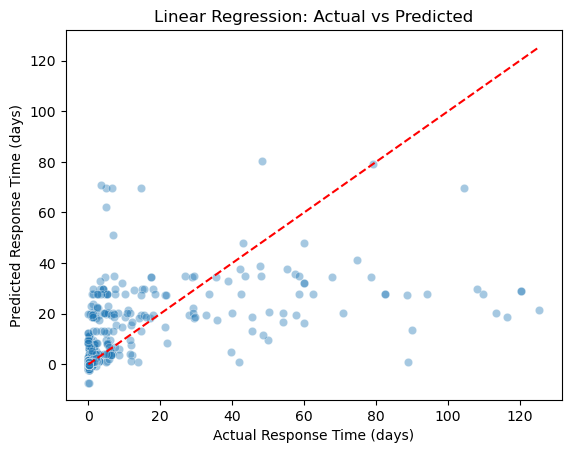


Random Forest Results:
MAE: 2.22, RMSE: 8.74, R2: 0.42


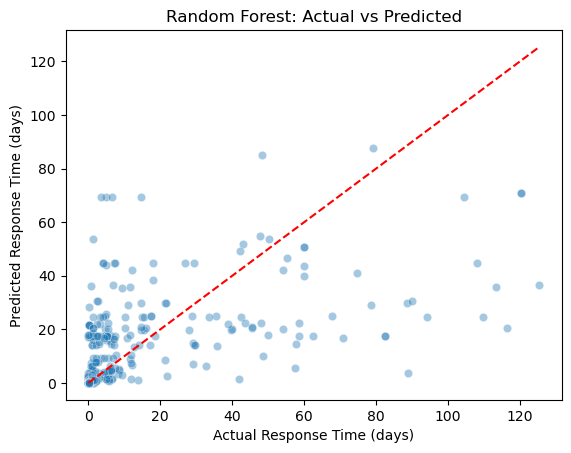

In [12]:
# Train models and evaluate
print("Training models...")
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name} Results:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

    # Plot predicted vs actual
    plt.figure()
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Response Time (days)")
    plt.ylabel("Predicted Response Time (days)")
    plt.title(f"{name}: Actual vs Predicted")
    plt.show()


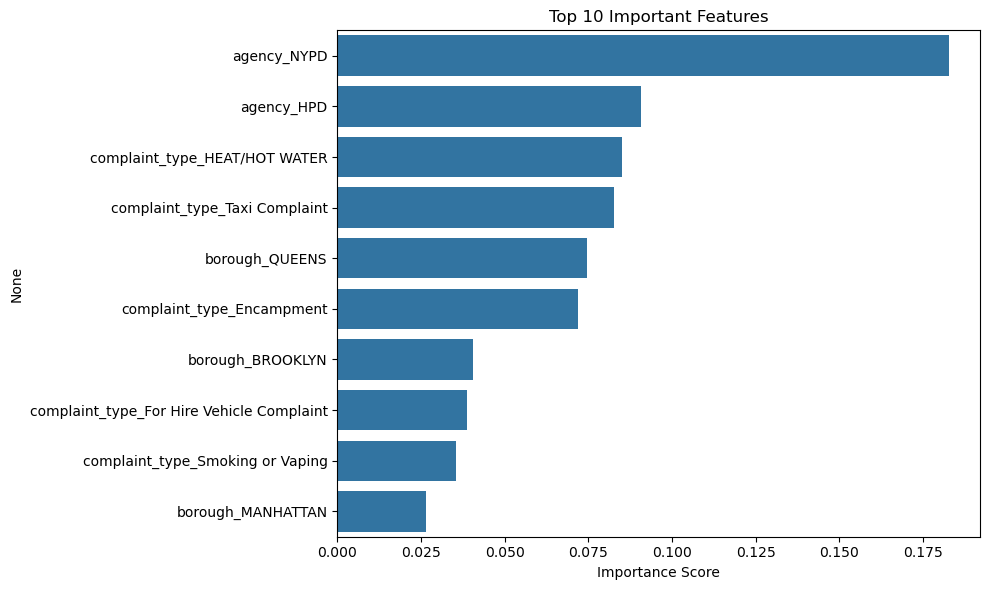

In [13]:
# feature importance (Note: Random Forest only)
rf_model = models["Random Forest"]
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[:10], y=importances.index[:10])
plt.title("Top 10 Important Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

## Interpreting Models

### Each model gives you three key evaluation scores: 

__MAE (Mean Absolute Error): On average, how many days is the model off by?__
>Linear Regression: 2.63 days <br>
>Random Forest: 2.22 days

__RMSE (Root Mean Squared Error): Like MAE but penalizes big errors more harshly.__
>Linear Regression: 9.24 days <br>
>Random Forest: 8.74 days

__R² Score (Coefficient of Determination): What proportion of the variance in resolution time is explained by the model? (Ranges from 0 to 1)__
>Linear Regression: 35% explained <br>
>Random Forest: 42% explained

In [ ]:
# Interpreting plots

# The x-axis is the actual resolution time (true value).
# The y-axis is the model’s predicted resolution time.
# The red line is the ideal (perfect prediction = all points fall on this line).
# Each dot is a 311 complaint.


# What to Look For:
# How close are points to the red line - the closer, the better.
# Are predictions biased toward the mean? Models like linear regression may “flatten” predictions toward the mean/average value.
# Outliers - check for large errors where predicted and actual values diverge.

In [ ]:
# Interpreting linear regression

# Shows a tendency to underpredict long resolution times (points fall below the red line).
# Predictions are more “compressed” — typical of linear models when the data isn’t linearly distributed.

In [ ]:
# Interpreting random forest models

# Shows a tendency to under-predict long resolution times (points fall below the red line).
# Predictions are more “compressed” — typical of linear models when the data isn’t linearly distributed.


### Reflection Questions

**Which model performed better overall? Why do you think that is?**
<br>Random Forest, it seems less flattened, i.e. does better with the larger numbers / outliers, and has a marginally higher R-squared value, indicating better performance

**Which features were most predictive?**
<br>Agency type, particulary for values NYPD and HPD (housing), as well as complaint type (for heat/hot water and taxis)

**What could be done to improve model performance? (e.g., more features, different models, more data)**
<br>Create more features based on different data columns - like 'Distance' from location data or time of day (i.e. night, late night, early morning, rush hour, etc) or day of week (mon-sun) from timestamp

**How might NYC agencies use this model to optimize service delivery?**
<br>Priortizing tickets that take longer or re-allocating staff/funds to areas that have longer service times. Can also use this as a decision making tool to for hiring or allocating funds into the departments that handle the requests that don't meet service level minimums (SLOs, etc.)

**How would you explain this model’s strengths and weaknesses to a policymaker or public official?**
<br>Knowing the reaction time for included features in our model allows agencies to plan better for all types of events, without needing to go out and collect data first. While this is an immensely helpful tool for activities like budget forecasting and operational planning, it's important to note that this data is based off historical data, which shows us *what* happend, not _why_ it happened. Meaning if certain regions were not served quickly due to racial discrimination let's say, then that will be incorprated into the model (i.e. those neighborhoods should still expect slow response times). Additionally, this model will work best for dealing events that occur in an average day, not usually for accounting for major events like Hurricane Sandy or 911.


#### SEVERITY MAPPING OF CATEGORICAL DATA

In [15]:
# identify complaint types in data
print(df["complaint_type"].value_counts().head(20))


complaint_type
Noise - Residential         4514
Illegal Parking             1104
HEAT/HOT WATER               815
Blocked Driveway             465
Noise - Street/Sidewalk      364
Noise - Commercial           221
Illegal Fireworks            217
Street Condition             157
UNSANITARY CONDITION         120
Abandoned Vehicle            106
PLUMBING                     101
Dirty Condition              100
Water System                  78
Noise - Vehicle               75
Traffic Signal Condition      73
Encampment                    68
Derelict Vehicles             68
PAINT/PLASTER                 67
Noise                         58
Illegal Dumping               53
Name: count, dtype: int64


In [16]:
# Create a dictionary to manually assign severity scores to the descriptor or complaint_type values in the dataset

# example severity map (can be expanded or customized)

severity_map = {
    "HEAT/HOT WATER": 3,
    "ELECTRIC": 3,
    "STRUCTURAL": 3,
    "WATER LEAK": 2,
    "PLUMBING": 2,
    "NOISE - STREET/SIDEWALK": 1,
    "ILLEGAL PARKING": 1,
    "GRAFFITI": 1,
    "GENERAL CONSTRUCTION": 1,
    "NOISE - RESIDENTIAL": 1,
    "RAT SIGHTING": 2,
    "MOLD": 2,
    "ELEVATOR": 3,
    # default category will be 0 (unknown or minor)
}

In [17]:
# Apply the mapping using complaint_type (can also switch to descriptor)
df["severity"] = df["complaint_type"].map(severity_map).fillna(0)

### ON YOUR OWN

In [ ]:
# Create your own models by adding new features (variables) to the data frame

# Options:
# Time of day (created_date.dt.hour) - df["hour"] = df["created_date"].dt.hour
# Day of the week (created_date.dt.dayofweek) - df["dayofweek"] = df["created_date"].dt.dayofweek
# Season, weekend/weekday flags
# Zip code groupings or geospatial clusters
# Complaint severity level (e.g., from descriptor)

# Go through the process of training and testing your model and observe how the findings change

### Model Summary

My model incorporates a severity scale - one that has greater range than the example mapping as it was run that way first, and no noticable difference was made. My model still didn't show much of a difference, so it removes capability type and instead focuses solely on severity type. Ultimately this led to a "flatter" and worse performing model, in both linear and random forest settings.


Training models...

Linear Regression Results:
MAE: 3.02, RMSE: 9.58, R2: 0.30


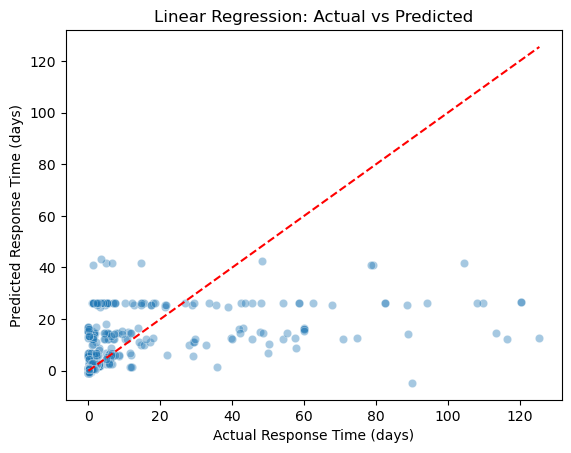


Random Forest Results:
MAE: 2.47, RMSE: 8.96, R2: 0.39


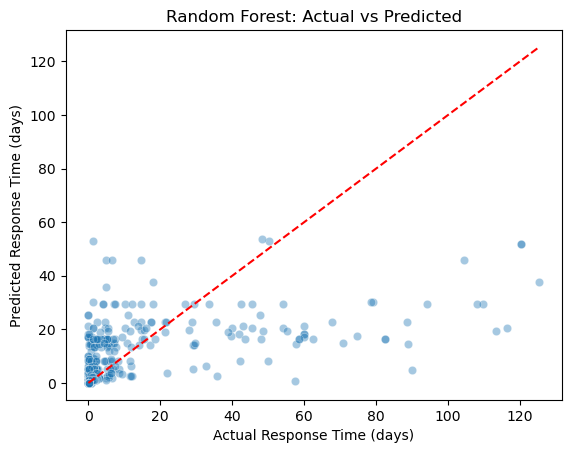

In [20]:
# 1. Create severity mapping
severity_map = {
    "HEAT/HOT WATER": 10,
    "ELECTRIC": 7,
    "STRUCTURAL": 9,
    "WATER LEAK": 6,
    "PLUMBING": 6,
    "NOISE - STREET/SIDEWALK": 4,
    "ILLEGAL PARKING": 4,
    "GRAFFITI": 1,
    "GENERAL CONSTRUCTION": 2,
    "NOISE - RESIDENTIAL": 2,
    "RAT SIGHTING": 1,
    "MOLD": 6,
    "ELEVATOR": 3,
    # default category = 0
}

# 2. Process datetime and compute response time
df["created_date"] = pd.to_datetime(df["created_date"], errors='coerce')
df["closed_date"] = pd.to_datetime(df["closed_date"], errors='coerce')
df = df.dropna(subset=["created_date", "closed_date"])
df = df.copy()  # avoid SettingWithCopyWarning

df["response_time_days"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / 86400
df = df[(df["response_time_days"] >= 0) & (df["response_time_days"] < 365)]

# 3. Apply severity mapping
df["severity"] = df["complaint_type"].map(severity_map).fillna(0).astype(int)

# 4. Prepare modeling dataset
df_model = df[["severity", "borough", "agency", "response_time_days"]].dropna()
df_model = pd.get_dummies(df_model, columns=["borough", "agency"], drop_first=True)

# 5. Train/test split
X = df_model.drop("response_time_days", axis=1)
y = df_model["response_time_days"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Train models and evaluate
print("Training models...")
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    
    print(f"\n{name} Results:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

    # Plot predicted vs actual
    plt.figure()
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
    plt.xlabel("Actual Response Time (days)")
    plt.ylabel("Predicted Response Time (days)")
    plt.title(f"{name}: Actual vs Predicted")
    plt.show()

### **Reflection Questions**


**How does your model reflect Grimmer et al.’s “agnostic” approach to ML?**
<br>My model begins to incorporate more qualitiative, non-binary elements of data but including severity, which fits in with Grimmer et al. arguement of going beyond the binary aspects of data, particularly when there is such a large ecosystem available. Where it probably falls short is that my severity mapping is subjective, rather than pulled from another agnostic or authoritative data source. I think this model / excercise also fits with their arguements as it is both flexible and iterative. Improvements to the model can still be made through experimentation, and different "versions" of the model can exist to fit different needs, like both the linear and random forest model serving different end users / needs.

**What tradeoffs did you notice between model complexity and interpretability? You can think about interpretability in terms of your ability to explain why the prediction was made and how different variables influenced the output.**
<br>Without isolating each feature it is very hard to determine what the impact to the model is when making multiple changes. I would imagine this gets even more difficult for more complex models.


**Would your model be trustworthy enough to support real-world decisions? Why/why not?**
<br>No, it should only be used as an information based tool, not a decision making one. But particularly becuase my model uses a subjective severity scale made without input / engagement from others and it's overall predictive abilities are weak (low R-squared score)
